In [48]:
import os
import sys
import time
import numpy as np
import psi4
import numpy as np
from tqdm import tqdm

In [49]:
def RL(A, k, mode='rl', learning_rate=0.5, discount=0.99, max_episode=30,
       max_pick=None,silent=False,ex=0):
    NDIM = len(A)
    if max_pick is None:
        max_pick = NDIM - k
    if mode == 'rl':
        E, idx = RL(A, k, mode='greedy')
        state = np.zeros((NDIM), dtype=np.int64)
        state[idx] = 1  # set topk rows from initialization to "active"
        active = np.argwhere(state == 1).reshape(-1,)
        inactive = np.argwhere(state == 0).reshape(-1,)
        assert len(active) == k
        assert len(inactive) == NDIM - k
        E, C = np.linalg.eigh(A[np.ix_(active, active)])
        E0, C0 = E[0], C[:, 0]
        E_best, state_best = E0, active
        w = np.zeros((NDIM))
        w[active] = np.abs(C0)  # from initial guess
        w[active] /= np.linalg.norm(w[active])  # normalize
        w[inactive] = perturb(A, state)  # PT guess at weights
        w[inactive] /= np.linalg.norm(w[inactive])  # normalize
        v = np.zeros_like(w)  # auxilliary weights
        if not silent:
            progress_bar = tqdm(range(max_episode))  # keep track of progress
        else:
            progress_bar = range(max_episode)  
        for episode in progress_bar:
            if not silent:
                progress_bar.set_description("Best energy: %.6f" % E_best)
            explore_rate = np.exp(-learning_rate*(episode+1))
            state *= 0
            if np.random.rand(1) < 0.75:
                active = np.argsort(w)[::-1][:k].reshape(-1,)
            else:
                active = state_best
            state[active] = 1
            inactive = np.argwhere(state == 0).reshape(-1,)
            E, C = np.linalg.eigh(A[np.ix_(active, active)])
            E0, C0 = E[0], C[:, 0]
            if E0 < E_best:
                E_best = E0
                state_best = active
            active_idx_sorted = np.argsort(w[active])  # sort asc
            selected = np.arange(len(w))[active][active_idx_sorted]
            cj = perturb(A, state)  # PT guess at weights
            inact_idx_sort = np.argsort(np.abs(cj))[::-1]  # desc
            expanded = np.arange(len(w))[inactive][inact_idx_sort][:max_pick]
            total_replaced = 0
            for j in range(max_pick):
                assert sum(state) == k  # make sure we have consistent # row
                is_replaced = False
                state[expanded[j]] = 1
                for i in range(k):
                    state[selected[i]] = 0
                    active = np.argwhere(state == 1).reshape(-1,)
                    inactive = np.argwhere(state == 0).reshape(-1,)
                    assert len(active) == k
                    assert len(inactive) == NDIM - k
                    E, C = np.linalg.eigh(A[np.ix_(active, active)])
                    Enew, Cnew = E[0], C[:, 0]
                    if Enew < E0 * (1 - explore_rate*np.random.rand(1)):
                        is_replaced = True
                        total_replaced += 1
                        state1 = np.zeros_like(state)
                        state1[selected] = 1
                        p = selected[i]
                        q = expanded[j]
                        sele1, sele2 = np.split(selected, [i])
                        selected = np.concatenate((sele1,
                                                   sele2[1:],
                                                   [expanded[j]]))
                        state2 = np.zeros_like(state)
                        state2[selected] = 1
                        active = np.argwhere(state2 == 1).reshape(-1,)
                        inactive = np.argwhere(state2 == 0).reshape(-1,)
                        R = E0 - Enew
                        if Enew < E_best:
                            E_best = Enew
                            state_best = active
                        E0 = Enew
                        C0 = Cnew
                        pp = np.arange(len(w))[active][np.argmin(w[active])]
                        qp = np.arange(len(w))[inactive][np.argmax(w[inactive])]
                        assert w[pp] == min(w[active])
                        assert w[qp] == max(w[inactive])
                        assert p not in active
                        delta = R + discount*np.dot(w,f(state2,(pp,qp))) - np.dot(w,f(state1,(p,q)))
                        aux = np.dot(f(state1,(p,q)),v) 
                        w += learning_rate *\
                             (delta*f(state1,(p,q)) - discount*aux*f(state2,(pp,qp)))
                        beta = np.sqrt(learning_rate) 
                        v += beta*(delta - aux)*f(state1,(p,q))
                        break
                    state[selected[i]] = 1
                if is_replaced is False:
                    state[expanded[j]] = 0

            if total_replaced == 0:
                break

        return E_best, state_best
    if mode == 'rle':
        E, idx = RL(A, k, mode='greedy')
        state = np.zeros((NDIM), dtype=np.int64)
        state[idx] = 1  # set topk rows from initialization to "active"
        active = np.argwhere(state == 1).reshape(-1,)
        inactive = np.argwhere(state == 0).reshape(-1,)
        assert len(active) == k
        assert len(inactive) == NDIM - k
#         E, C = np.linalg.eigh(A[np.ix_(active, active)])
        E0, C0 = chi(A,state)
#         E0, C0 = E[2], C[:, 2]
        E_best, state_best = E0, active
        w = np.zeros((NDIM))
        w[active] = np.abs(C0)  # from initial guess
        w[active] /= np.linalg.norm(w[active])  # normalize
        w[inactive] = perturb(A, state)  # PT guess at weights
        w[inactive] /= np.linalg.norm(w[inactive])  # normalize
        v = np.zeros_like(w)  # auxilliary weights
        if not silent:
            progress_bar = tqdm(range(max_episode))  # keep track of progress
        else:
            progress_bar = range(max_episode)  
        for episode in progress_bar:
            if not silent:
                progress_bar.set_description("Best energy: %.6f" % E_best)
            explore_rate = np.exp(-learning_rate*(episode+1))
            state *= 0
            if np.random.rand(1) < 0.75:
                active = np.argsort(w)[::-1][:k].reshape(-1,)
            else:
                active = state_best
            state[active] = 1
            inactive = np.argwhere(state == 0).reshape(-1,)
#             E, C = np.linalg.eigh(A[np.ix_(active, active)])
            E0, C0 = chi(A,state)
            if E0 < E_best:
                E_best = E0
                state_best = active
            active_idx_sorted = np.argsort(w[active])  # sort asc
            selected = np.arange(len(w))[active][active_idx_sorted]
            cj = perturbex(A, state)  # PT guess at weights
            inact_idx_sort = np.argsort(np.abs(cj))[::-1]  # desc
            expanded = np.arange(len(w))[inactive][inact_idx_sort][:max_pick]
            total_replaced = 0
            for j in range(max_pick):
                assert sum(state) == k  # make sure we have consistent # row
                is_replaced = False
                state[expanded[j]] = 1
                for i in range(k):
                    state[selected[i]] = 0
                    active = np.argwhere(state == 1).reshape(-1,)
                    inactive = np.argwhere(state == 0).reshape(-1,)
                    assert len(active) == k
                    assert len(inactive) == NDIM - k

#                     E, C = np.linalg.eigh(A[np.ix_(active, active)])
                    Enew, Cnew = chi(A,state)
                    if Enew < E0 * (1 - explore_rate*np.random.rand(1)):
                        is_replaced = True

                        total_replaced += 1
                        state1 = np.zeros_like(state)
                        state1[selected] = 1
                        p = selected[i]
                        q = expanded[j]

                        sele1, sele2 = np.split(selected, [i])
                        selected = np.concatenate((sele1,
                                                   sele2[1:],
                                                   [expanded[j]]))

                        # update state
                        state2 = np.zeros_like(state)
                        state2[selected] = 1
                        active = np.argwhere(state2 == 1).reshape(-1,)
                        inactive = np.argwhere(state2 == 0).reshape(-1,)
                        R = E0 - Enew
                        if Enew < E_best:
                            E_best = Enew
                            state_best = active
                        E0 = Enew
                        C0 = Cnew
                        pp = np.arange(len(w))[active][np.argmin(w[active])]
                        qp = np.arange(len(w))[inactive][np.argmax(w[inactive])]
                        assert w[pp] == min(w[active])
                        assert w[qp] == max(w[inactive])
                        assert p not in active
                        delta = R + discount*np.dot(w,f(state2,(pp,qp))) - np.dot(w,f(state1,(p,q)))
                        aux = np.dot(f(state1,(p,q)),v) 
                        w += learning_rate *\
                             (delta*f(state1,(p,q)) - discount*aux*f(state2,(pp,qp)))
                        beta = np.sqrt(learning_rate) 
                        v += beta*(delta - aux)*f(state1,(p,q))
                        break
                    state[selected[i]] = 1
                if is_replaced is False:
                    state[expanded[j]] = 0
            if total_replaced == 0:
                break
        return E_best, state_best
    elif mode == 'apsci':
        E, C = np.linalg.eigh(A)
        idx = np.argpartition(np.abs(C[:, 0]), -k)[-k:]
        A1 = A[np.ix_(idx, idx)]
        E_apsci = np.linalg.eigvalsh(A1)[0]
        return E_apsci, idx
    elif mode == 'greedy':
        state = np.zeros((NDIM))
        for i in range(k):
            if i == 0:
                state[0] = 1
            active = np.argwhere(state == 1).reshape(-1,)
            inactive = np.argwhere(state == 0).reshape(-1,)
            A1 = A[np.ix_(active, active)]
            E, C = np.linalg.eigh(A1)
            E0, C0 = E[0], C[:, 0]
            if i < k - 1:
                cj = perturb(A, state)
                cj_idx = np.argmax(np.abs(cj))
                state[np.arange(NDIM)[inactive][cj_idx]] = 1
            else:
                break
        E_greedy = E0
        idx = np.argwhere(state == 1)
        assert len(idx) == k
        return E_greedy, idx
    elif mode == 'greedyex':
        state = np.zeros((NDIM))
        for i in range(k):
            if i == 0:
                state[0] = 1
            active = np.argwhere(state == 1).reshape(-1,)
            inactive = np.argwhere(state == 0).reshape(-1,)
            A1 = A[np.ix_(active, active)]
            E, C = np.linalg.eigh(A1)
            E0, C0 = E[0], C[:, 0]
            if i < k - 1:
                cj = perturb(A, state)
                cj_idx = np.argmax(np.abs(cj))
                state[np.arange(NDIM)[inactive][cj_idx]] = 1
            else:
                break
        E_greedy = E0
        idx = np.argwhere(state == 1)
        assert len(idx) == k
        return E_greedy, idx
    elif mode == 'full':
        return np.linalg.eigvalsh(A)[0], None

def f(state,a):
    active = np.argwhere(state == 1).reshape(-1,) 
    vector = np.zeros_like(state)
    p,q = a
    assert state[p] == 1
    assert state[q] == 0
    vector[active] = 1
    vector[q] =  1
    vector[p] = -1
    return vector/np.linalg.norm((vector))

def perturb(A, state):
    active = np.argwhere(state == 1).reshape(-1,)  # active row indices
    inactive = np.argwhere(state == 0).reshape(-1,)  # inactive row indices
    E, C = np.linalg.eigh(A[np.ix_(active, active)])
    E0, C0 = E[0], C[:, 0]
    a = np.minimum(1e5, np.abs(np.dot(A[np.ix_(inactive, active)], C0)))
    b = np.maximum(1e-5, np.abs(E0-np.diagonal(A[np.ix_(inactive, inactive)])))
    c = np.true_divide(a, b)
    return c



In [50]:

psi4.core.set_output_file('output.dat', False)

numpy_memory = 14

mol = psi4.geometry("""
O
H 1 1.1
H 1 1.1 2 104
symmetry c1

""")
#                     H-He 	                Li-Ne                   	Na-Ar 
# cc-pVDZ   	[2s1p] → 5 func. 	    [3s2p1d] →   14 func. 	    [4s3p1d] → 18 func.
# cc-pVTZ   	[3s2p1d] → 14 func. 	[4s3p2d1f] → 30 func. 	    [5s4p2d1f] → 34 func.
# cc-pVQZ   	[4s3p2d1f] → 30 func. 	[5s4p3d2f1g] → 55 func. 	[6s5p3d2f1g] → 59 func.
# aug-cc-pVDZ 	[3s2p] → 9 func. 	    [4s3p2d] → 23 func.     	[5s4p2d] → 27 func.
# aug-cc-pVTZ 	[4s3p2d] → 23 func. 	[5s4p3d2f] → 46 func.   	[6s5p3d2f] → 50 func.
# aug-cc-pVQZ 	[5s4p3d2f] → 46 func. 	[6s5p4d3f2g] → 80 func. 	[7s6p4d3f2g] → 84 func. 
psi4.set_options({'basis': 'STO-6G', 'scf_type': 'pk', 'e_convergence': 1e-8, 'd_convergence': 1e-8})

print('\nStarting SCF and integral build...')

scf_e, wfn = psi4.energy('SCF', return_wfn=True)

C = wfn.Ca()

ndocc = wfn.doccpi()[0]
nmo = wfn.nmo()
nvirt = nmo - ndocc
print(ndocc,nmo,nvirt)




Starting SCF and integral build...
5 7 2


In [51]:
t = time.time()
print("may be energy :",psi4.energy('DETCI'))
print('\nPSI4 cisd cal: %.3f seconds.\n' % (time.time() - t))


may be energy : -75.72648934089273

PSI4 cisd cal: 0.202 seconds.



In [52]:
mints = psi4.core.MintsHelper(wfn.basisset())
H = np.asarray(mints.ao_kinetic()) + np.asarray(mints.ao_potential())


MO = np.asarray(mints.mo_spin_eri(C, C))
Vee = np.asarray(mints.mo_eri(C,C,C,C))

H = np.einsum('uj,vi,uv', C, C, H)
Hone = H.copy()
H = np.repeat(H, 2, axis=0)
H = np.repeat(H, 2, axis=1)

spin_ind = np.arange(H.shape[0], dtype=np.int64) % 2
H *= (spin_ind.reshape(-1, 1) == spin_ind)

In [53]:
from scipy.special import comb
nDet_S = ndocc * nvirt * 2
nDet_D = 2 * comb(ndocc, 2) * comb(nvirt, 2) + ndocc**2 * nvirt**2
nDet = 1 + nDet_S + nDet_D


# nDet = comb(nmo, ndocc)**2

# print("FCI nDet :" ,nDet)
from helper_CI import Determinant, HamiltonianGenerator
from itertools import combinations

print('Generating %d CIS singlet Determinants...' % (nDet_S + 1))
t = time.time()

occList = [i for i in range(ndocc)]
det_ref = Determinant(alphaObtList=occList, betaObtList=occList)
detList = det_ref.generateSingleExcitationsOfDet(nmo)
detList.append(det_ref)

print('..finished generating determinants in %.3f seconds.\n' % (time.time() - t))

print('Generating Hamiltonian Matrix...')

t = time.time()
Hamiltonian_generator = HamiltonianGenerator(H, MO)
Hamiltonian_matrixCIS = Hamiltonian_generator.generateMatrix(detList)

Generating 21 CIS singlet Determinants...
..finished generating determinants in 0.000 seconds.

Generating Hamiltonian Matrix...


In [54]:

print('Generating %d CISD Determinants...' % (nDet))

occList = [i for i in range(ndocc)]

det_ref = Determinant(alphaObtList=occList, betaObtList=occList)

detList = det_ref.generateSingleAndDoubleExcitationsOfDet(nmo)
detList.append(det_ref)

Hamiltonian_generator = HamiltonianGenerator(H, MO)
Hamiltonian_matrixCISD = Hamiltonian_generator.generateMatrix(detList)


Generating 141 CISD Determinants...


In [55]:
nDet = comb(nmo, ndocc)**2
print('Generating %d Full CI Determinants...' % (nDet))
detList = []
for alpha in combinations(range(nmo), ndocc):
    for beta in combinations(range(nmo), ndocc):
        detList.append(Determinant(alphaObtList=alpha, betaObtList=beta))


t = time.time()
Hamiltonian_generator = HamiltonianGenerator(H, MO)
Hamiltonian_matrixFCI = Hamiltonian_generator.generateMatrix(detList)

Generating 441 Full CI Determinants...


In [56]:
e_cis, wavefunctions = np.linalg.eigh(Hamiltonian_matrixCIS)
e_cisd, wavefunctions = np.linalg.eigh(Hamiltonian_matrixCISD)
e_fci, wavefunctions = np.linalg.eigh(Hamiltonian_matrixFCI)
for i in range(0,10):
        print("Energies ",i,"FCI :% 16.15f"% (e_fci[i]),"CISD   :% 16.15f"% (e_cisd[i]),"CIS   :% 16.15f"% (e_cis[i]))
        


Energies  0 FCI :-83.730648587054418 CISD   :-83.728855823066269 CIS   :-83.659154377760302
Energies  1 FCI :-83.457159196041829 CISD   :-83.426311291330066 CIS   :-83.374856891318117
Energies  2 FCI :-83.409932220195714 CISD   :-83.378450382307022 CIS   :-83.319206897604531
Energies  3 FCI :-83.374575012981808 CISD   :-83.339840345742715 CIS   :-83.306092641671881
Energies  4 FCI :-83.366779618225650 CISD   :-83.336968241016535 CIS   :-83.296350826200992
Energies  5 FCI :-83.340405009990363 CISD   :-83.306470799506116 CIS   :-83.269757085011818
Energies  6 FCI :-83.307981908309642 CISD   :-83.277003105910410 CIS   :-83.246546349358127
Energies  7 FCI :-83.240599056191726 CISD   :-83.221305551089770 CIS   :-83.157716325526295
Energies  8 FCI :-83.193928679946225 CISD   :-83.180092869150755 CIS   :-83.149490450908829
Energies  9 FCI :-83.183946532269573 CISD   :-83.169141718254352 CIS   :-83.108841139382534


In [57]:
A= Hamiltonian_matrixFCI
from numpy import count_nonzero
sparsity = len(A)*np.sqrt( count_nonzero(A) / float(A.size) )
print(sparsity)
k = 141  # sparsity
print("k:    ", k)
print("NDet: ", len(A))

E_exact = RL(A, k, mode='full') 
print("Exact:  ", E_exact)

E_apsci, sapsci = RL(A, k, mode='apsci')
print("ap-sCI: ", E_apsci)

E_greedy, sgreedy = RL(A, k, mode='greedy')
print("greedy: ", E_greedy)

249.36118382779628
k:     141
NDet:  441
Exact:   (-83.73064858705433, None)
ap-sCI:  -83.73064858705439
greedy:  -83.73064858705445


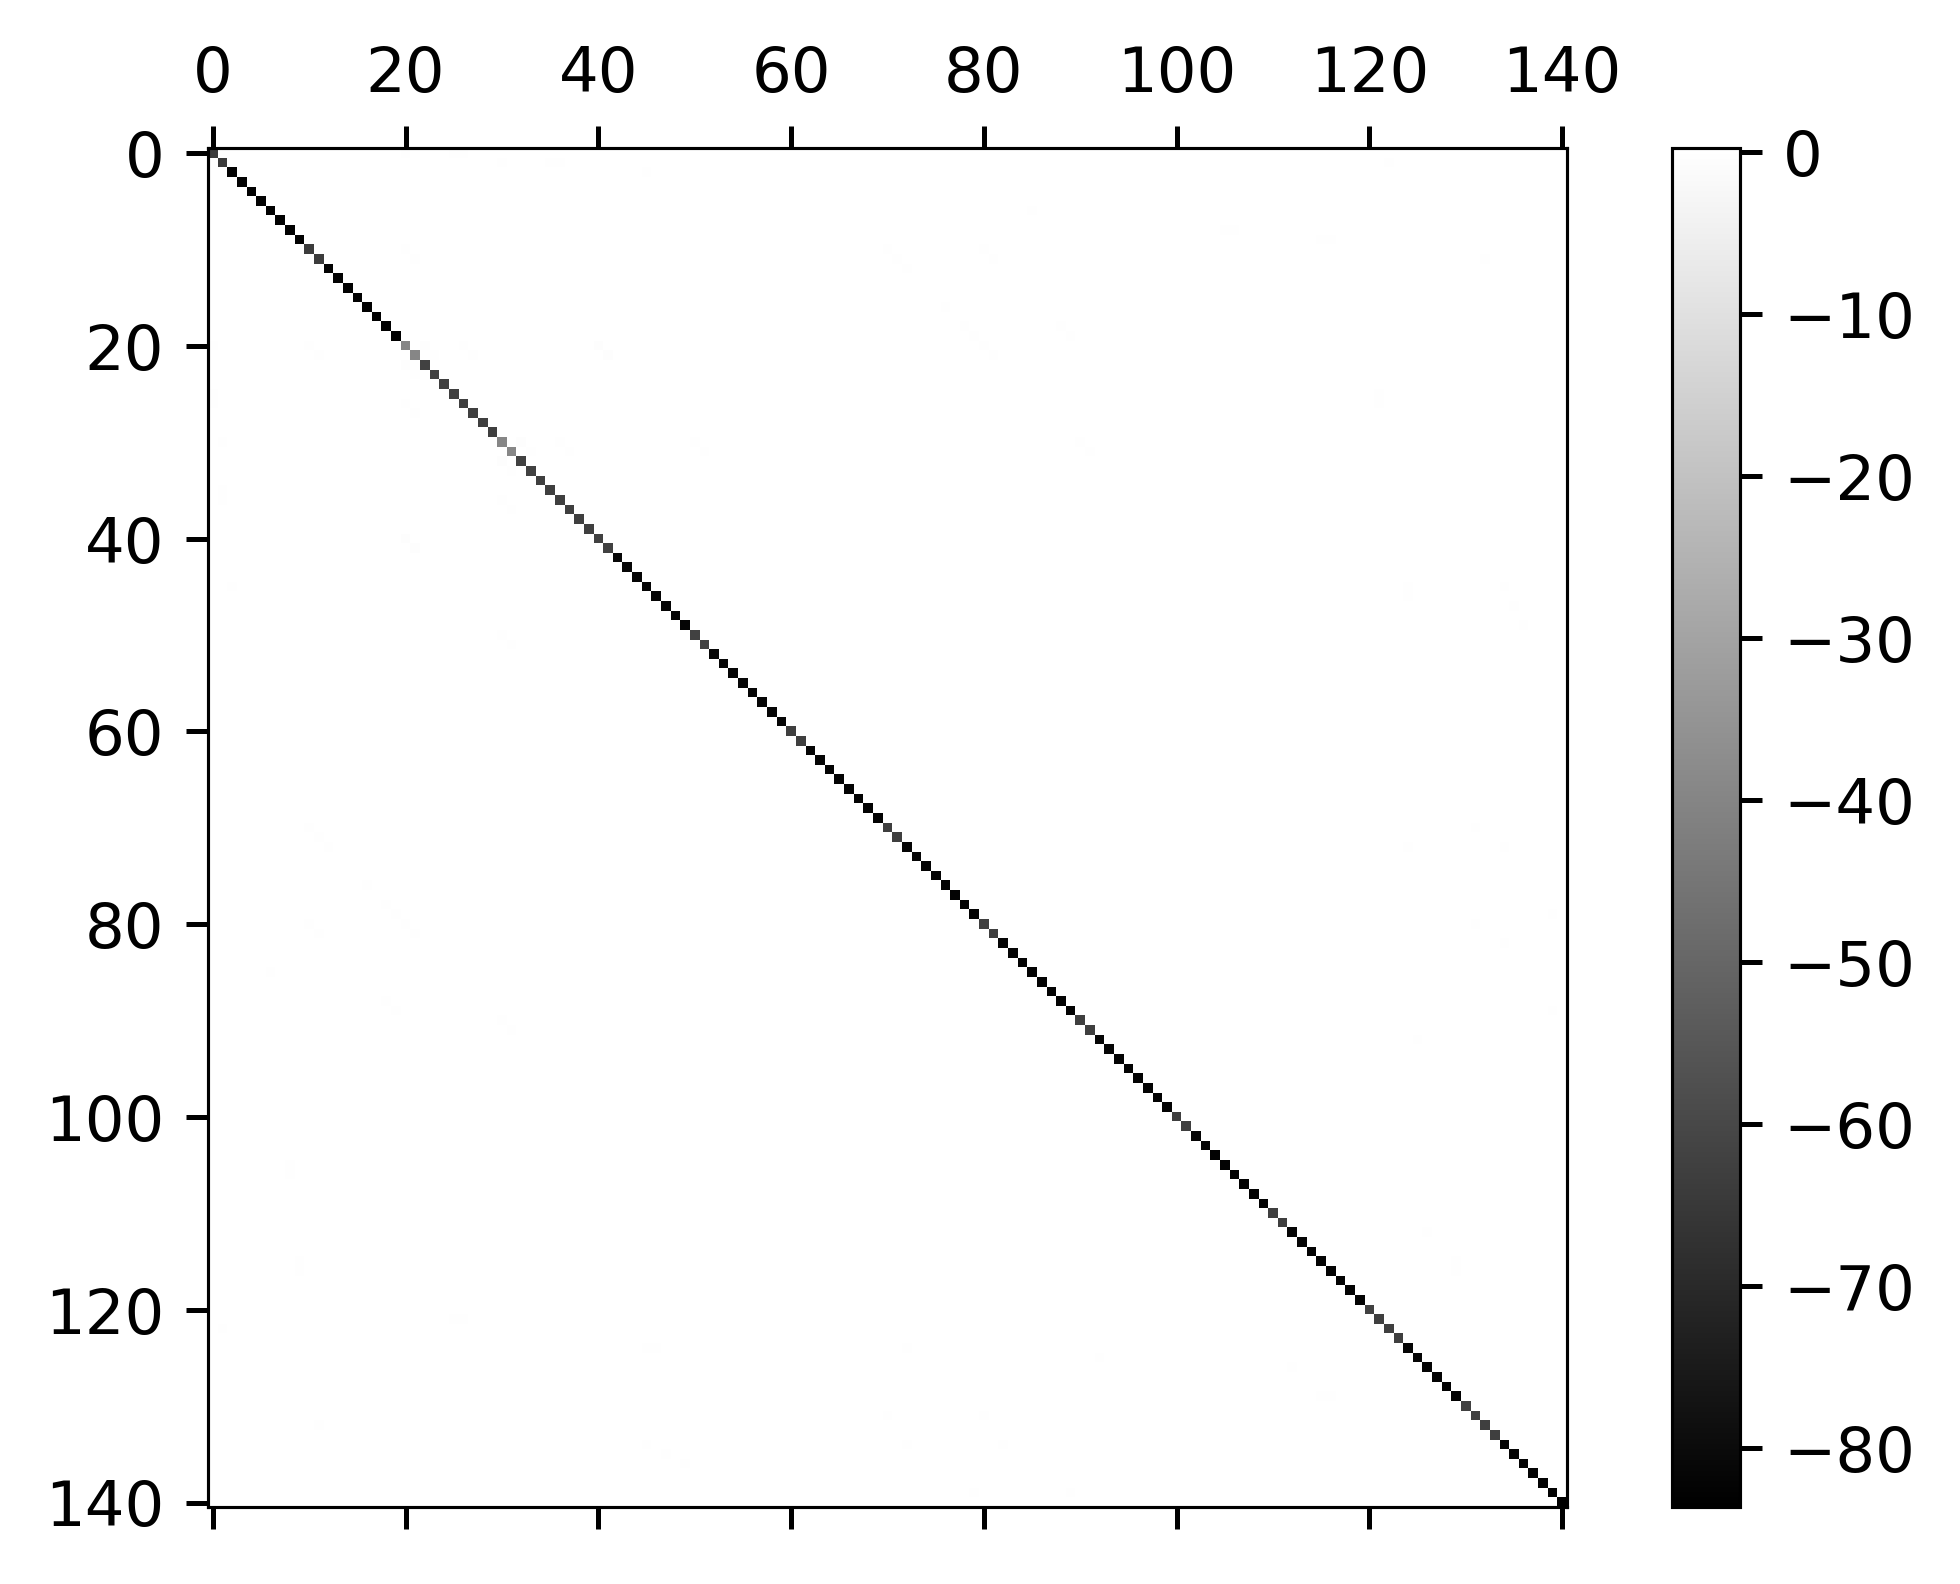

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
figure = plt.figure(dpi=450)
axes = figure.add_subplot(111)
# axes.xaxis.set_tick_params(which='major', size=0, width=0, direction='in', top='on')
# axes.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
# plt.rcParams['axes.linewidth'] = 0.5
# axes.spy(Hamiltonian_matrixCISD, markersize=0.5)
caxes = axes.matshow(Hamiltonian_matrixCISD, interpolation ='nearest',cmap="binary_r")
figure.colorbar(caxes)
# plt.grid()
# plt.xticks(np.arange(0, 140, 1.0))
# plt.yticks(np.arange(0, 140, 1.0))
# plt.axis('off')
# plt.grid()
# axes.set_xticklabels(['']+alphabets)
# axes.set_yticklabels(['']+alphabets)
 
plt.show()

In [59]:
s= np.array([x[0] for x in sgreedy[:]])
# print(s)
E, C = np.linalg.eigh(A[np.ix_(sapsci, sapsci)])
Eg, C = np.linalg.eigh(A[np.ix_(s, s)])
# Eex, C = np.linalg.eigh(A[np.ix_(sgreedyex, sgreedyex)])
for i in range(0,10):
        print(i,"FCI :% 16.15f"% (e_fci[i]),"CISD   :% 16.15f"% (e_cisd[i]),"ap-sCI :% 16.15f"% (E[i]),"Greedy :% 16.15f"% (Eg[i]))
#     print(i,"CISD   :% 16.15f"% (e_cisd[i]),"ap-sCI :% 16.15f"% (E[i]),"Greedy :% 16.15f"% (Eg[i]))

0 FCI :-83.730648587054418 CISD   :-83.728855823066269 ap-sCI :-83.730648587054418 Greedy :-83.730648587054446
1 FCI :-83.457159196041829 CISD   :-83.426311291330066 ap-sCI :-83.366779618225621 Greedy :-83.366779618225635
2 FCI :-83.409932220195714 CISD   :-83.378450382307022 ap-sCI :-83.340474766494950 Greedy :-83.240599056191712
3 FCI :-83.374575012981808 CISD   :-83.339840345742715 ap-sCI :-83.271448587779588 Greedy :-83.221311352404783
4 FCI :-83.366779618225650 CISD   :-83.336968241016535 ap-sCI :-83.240599056191755 Greedy :-83.152707295314059
5 FCI :-83.340405009990363 CISD   :-83.306470799506116 ap-sCI :-83.195637185622701 Greedy :-83.144437235904149
6 FCI :-83.307981908309642 CISD   :-83.277003105910410 ap-sCI :-83.152707295314087 Greedy :-83.039355854707182
7 FCI :-83.240599056191726 CISD   :-83.221305551089770 ap-sCI :-83.050106490959649 Greedy :-82.985663178250249
8 FCI :-83.193928679946225 CISD   :-83.180092869150755 ap-sCI :-82.985663178250206 Greedy :-82.934059565910090
9

In [60]:
E_rl, sg = RL(A, k, mode='rl', max_pick=None)

Best energy: -333.559339:   0%|                                                                                                                                                         | 0/30 [00:00<?, ?it/s]


NameError: name 'a' is not defined

In [67]:
def perturbex(A, state):
    active = np.argwhere(state == 1).reshape(-1,)  # active row indices
    inactive = np.argwhere(state == 0).reshape(-1,)  # inactive row indices
    E, C = np.linalg.eigh(A[np.ix_(active, active)])
    n=4
    a=[1,0.8,0.6,0.4]
    Cc=[]
    for i in range(0,n):
        En, Cn = E[0], C[:, 0]
        an = np.minimum(1e5, np.abs(np.dot(A[np.ix_(inactive, active)], Cn)))
        bn = np.maximum(1e-5, np.abs(En-np.diagonal(A[np.ix_(inactive, inactive)])))
        cn = np.true_divide(an, bn)
        Cc.append(cn*a[i])
    Cc=np.asarray(Cc)
    Cc=Cc.sum(axis=0)
    return Cc/np.linalg.norm((Cc))

def chi(A,state):
    active = np.argwhere(state == 1).reshape(-1,)  # active row indices
    inactive = np.argwhere(state == 0).reshape(-1,)  # inactive row indices
    E, C = np.linalg.eigh(A[np.ix_(active, active)])
    a=[1,0.8,0.6,0.4]
    Ec=a[0]*E[0]+a[1]*E[1]+a[2]*E[2]+a[3]*E[3]
#     Cc=np.add(C[0],C[1],C[2],C[3])
    Cc=a[0]*[0]+a[1]*C[1]+a[2]*C[2]+a[3]*C[3]
    return Ec,Cc/np.linalg.norm((Cc))
E_rle, sge = RL(A, k, mode='rle', max_pick=None)

Best energy: -233.881663: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [10:14<00:00, 20.49s/it]


In [ ]:
# print(len(sg),len(se1),len(se2),len(se3),len(se4),len(se5))
# print(se)

# t = np.unique(np.concatenate((sg,se1,se2,se3,se4,se5),0))

In [ ]:
# print(sg)
# print(se)
# print(t)

In [68]:

# print(len(sg),len(t))
E, C = np.linalg.eigh(A[np.ix_(sg, sg)])
Ee, C = np.linalg.eigh(A[np.ix_(sge, sge)])
for i in range(0,10):
        print("Energies ",i,"FCI :% 16.15f"% (e_fci[i]),"CISD   :% 16.15f"% (e_cisd[i]),"RLCI :% 16.15f"% (E[i]),"RLCIe :% 16.15f"% (Ee[i]))
#         print("Energies ",i,"CISD   :% 16.15f"% (e_cisd[i]),"RLCI :% 16.15f"% (E[i])),"RLCIe :% 16.15f"% (Ee[i]))

Energies  0 FCI :-83.730648587054418 CISD   :-83.728855823066269 RLCI :-83.730648587054446 RLCIe :-83.729785520391715
Energies  1 FCI :-83.457159196041829 CISD   :-83.426311291330066 RLCI :-83.366779618225635 RLCIe :-83.454134520315307
Energies  2 FCI :-83.409932220195714 CISD   :-83.378450382307022 RLCI :-83.240599056191712 RLCIe :-83.406550713094219
Energies  3 FCI :-83.374575012981808 CISD   :-83.339840345742715 RLCI :-83.221311352404783 RLCIe :-83.362588257367335
Energies  4 FCI :-83.366779618225650 CISD   :-83.336968241016535 RLCI :-83.152707295314059 RLCIe :-83.234033491891921
Energies  5 FCI :-83.340405009990363 CISD   :-83.306470799506116 RLCI :-83.144437235904149 RLCIe :-83.138236531463036
Energies  6 FCI :-83.307981908309642 CISD   :-83.277003105910410 RLCI :-83.039355854707182 RLCIe :-82.994472798001340
Energies  7 FCI :-83.240599056191726 CISD   :-83.221305551089770 RLCI :-82.985663178250249 RLCIe :-82.964001872331380
Energies  8 FCI :-83.193928679946225 CISD   :-83.1800928

In [ ]:
plt.clf()
figure = plt.figure(dpi=450)
axes = figure.add_subplot(111)
axes.spy(A[np.ix_(sg, sg)], markersize=0.5)
# y=A[np.ix_(sg, sg)]
# np.fill_diagonal(y, 0)
# caxes = axes.matshow(y, interpolation ='nearest',cmap="coolwarm")
# figure.colorbar(caxes)

plt.show()